# Problem 1

Please load `data.mat` into your Python code, where you will find $x, y \in \mathbb{R}^{1001}$.

Now, do the following procedures.

## Solution

In [47]:
import torch
from scipy.io import loadmat

data = loadmat("data.mat")
x = torch.as_tensor(data["x"], dtype=torch.float32)
y = torch.as_tensor(data["y"], dtype=torch.float32)

display(dict(x_dim=x.shape.numel(), y_dim=y.shape.numel()))

{'x_dim': 1001, 'y_dim': 1001}

# Problem 1.1

Use the plot function to visualize the data.

## Solution

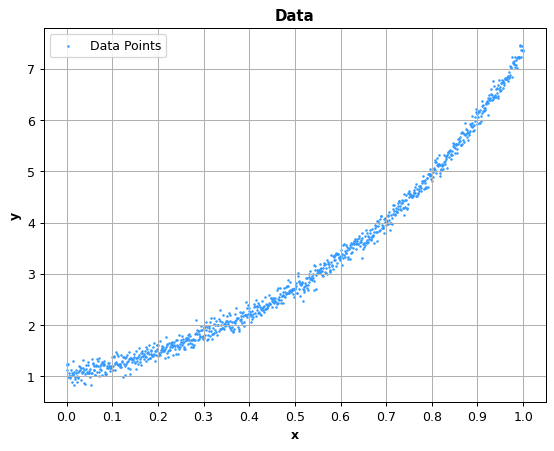

In [48]:
import matplotlib.pyplot as plt


def plot_data(
    x: torch.Tensor,
    y: torch.Tensor,
    *,
    scale: float | None = None,
    label: str | None = None,
) -> None:
    scale = float(scale) or 1.0
    label = str(label or "Data Points")

    # Create the canvas
    plt.figure(dpi=100 * scale, figsize=(8 * scale, 6 * scale))

    # Draw the grid
    x_min, x_max = x.min(), x.max()
    plt.xticks(torch.arange(x_min, x_max * 1.1, (x_max - x_min) / 10))
    plt.xlabel("x", fontweight="bold")
    plt.ylabel("y", fontweight="bold")
    plt.grid(True)

    # Plot the data points
    plt.scatter(x, y, c="#39F", s=1, label=label)
    plt.legend()


plot_data(x, y, scale=0.9)
plt.title("Data", fontweight="bold")
plt.show()

# Problem 1.2

Compute the least square line $y = \theta_0 + x \theta_1$ using the given data and overlay 
the line on the given data.

## Solution

Let $\hat{\mathbf{y}} = \mathbf{x}^{0} \theta_0 + \mathbf{x}^{1} \theta_1 + \ldots + \mathbf{x}^{p - 1} \theta_{p - 1},\ \mathbf{x},\ \mathbf{y},\ \hat{\mathbf{y}} \in \mathbb{R}^{n},\ \theta_i \in \mathbb{R},\ n,\ p \in \mathbb{N}$.

The goal is to find the least $\mathcal{L} = \| \mathbf{y} - \hat{\mathbf{y}} \|_2^2$.

Let $\boldsymbol{\theta} = [\theta_0\ \theta_1 \ldots\ \theta_{p - 1}]^{T} \in \mathbb{R}^{p \times 1},\ \mathbf{X} = [\mathbf{x}^{0}\ \mathbf{x}^{1} \ldots\ \mathbf{x}^{p - 1}] \in \mathbb{R}^{n \times p}$.

We can rewrite $\mathcal{L}$ as $(\mathbf{y} - \mathbf{X} \boldsymbol{\theta})^{T}(\mathbf{y} - \mathbf{X} \boldsymbol{\theta})$ and $\mathbf{\hat{y}}$ as $\mathbf{X} \boldsymbol{\theta}$.

Then, $\nabla \mathcal{L} = \frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \frac{\partial \mathcal{L}}{\partial (\mathbf{y} - \mathbf{X} \boldsymbol{\theta})} \frac{\partial (\mathbf{y} - \mathbf{X} \boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = -2(\mathbf{y} - \mathbf{X} \boldsymbol{\theta}) \mathbf{X}^{T}$.

We know that $\mathcal{L}$ is minimal iff $\nabla \mathcal{L} = 0$. Then, $\boldsymbol{\theta} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$.

In [65]:
from dataclasses import dataclass
import torch
from typing import Callable


@dataclass
class LeastSquareOutput:
    coefficients: torch.Tensor
    predictor: Callable[[torch.Tensor], torch.Tensor]


def least_square(x: torch.Tensor, y: torch.Tensor, degree: int) -> LeastSquareOutput:
    def get_X(x: torch.Tensor) -> torch.Tensor:
        x = torch.as_tensor(x).flatten()
        return torch.stack([x**p for p in range(degree + 1)], dim=1)

    X = get_X(x)
    y = torch.as_tensor(y).flatten()
    θ = (X.T @ X).inverse() @ X.T @ y
    y_hat_f = lambda x: get_X(x).matmul(θ).reshape_as(x)

    return LeastSquareOutput(coefficients=θ, predictor=y_hat_f)

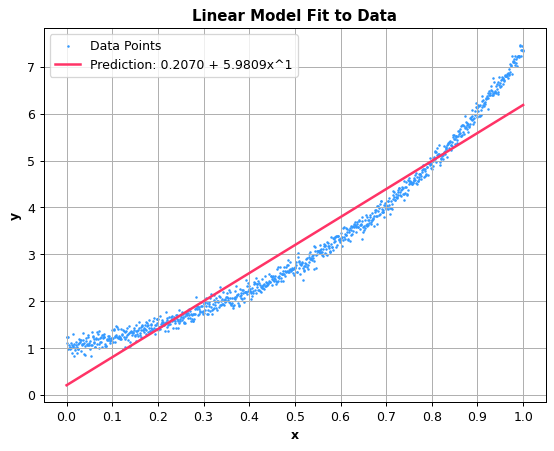

In [66]:
from matplotlib import pyplot as plt


def plot_least_square_model_and_data(
    x: torch.Tensor,
    y: torch.Tensor,
    degree: int,
    *,
    name: str,
) -> None:
    result = least_square(x, y, int(degree))
    c = result.coefficients
    f = f"{c[0]:.4f} + " + " + ".join([f"{c[i]:.4f}x^{i}" for i in range(1, len(c))])

    plot_data(x, y, scale=0.9)
    plt.title(f"{name} Model Fit to Data", fontweight="bold")
    plt.plot(x, result.predictor(x), c="#F36", lw=2, label=f"Prediction: {f}")
    plt.legend()
    plt.show()


plot_least_square_model_and_data(x, y, 1, name="Linear")

# Problem 1.3

Fit a least squares second-order polynomial ($y = \theta_0 + x \theta_1 + x^2 \theta_2$) to the data.

## Solution

Use the same method as in Problem 1.2, $p = 3$.

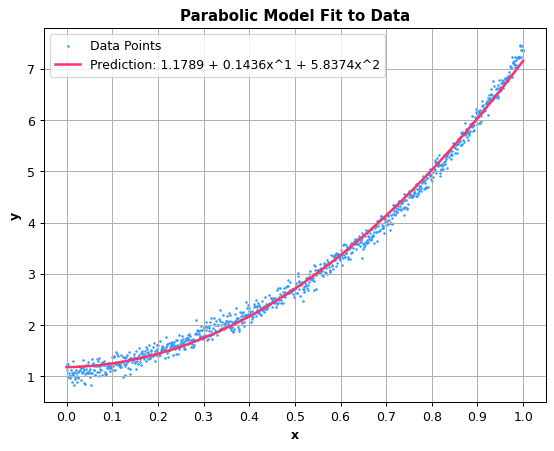

In [51]:
plot_least_square_model_and_data(x, y, 2, name="Parabolic")

# Problem 1.4

Fit a least squares quartic curve ($y = \theta_0 + x \theta_1 + x^2 \theta_2 + x^3 \theta_3 + x^4 \theta_4$) to the data.

## Solution

Use the same method as in Problem 1.2, $p = 5$.

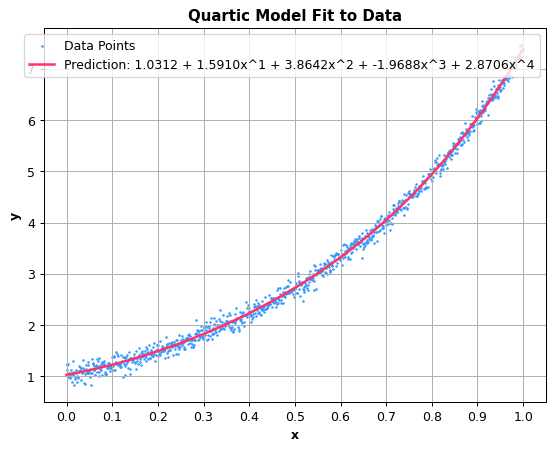

In [52]:
plot_least_square_model_and_data(x, y, 4, name="Quartic")

# Problem 1.5

Analyze which model (line, parabola, or quartic curve) is the most appropriate for this dataset.

Justify your answer by calculating and comparing the mean squared error (MSE) for each fitting model.

## Solution

We can measure the MSEs of prediction and ground truth of all model and compare them.

The most appropriate model for this dataset has the lowest MSE.

$MSE(\mathbf{y},\ \hat{\mathbf{y}}) = \frac{1}{n} \| \mathbf{y} - \hat{\mathbf{y}} \|_2^2$.

In [53]:
from torch import Tensor


def get_mean_squared_error(output: Tensor, target: Tensor) -> Tensor:
    return ((output - target) ** 2).mean()

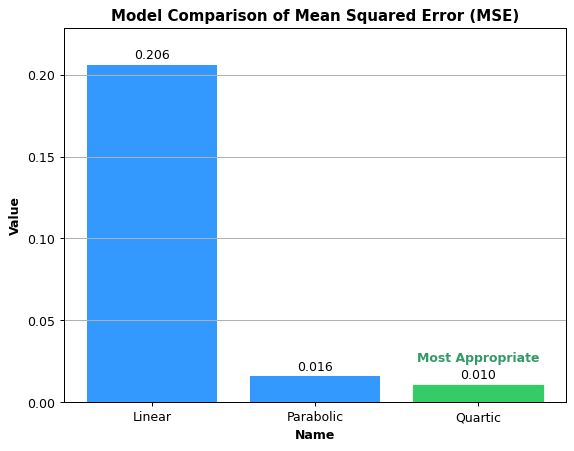

In [54]:
from matplotlib import pyplot as plt


def plot_bar(x: list[str], y: list[float], *, scale: float | None = None):
    scale = float(scale) or 1.0

    # Create the canvas
    plt.figure(dpi=100 * scale, figsize=(8 * scale, 6 * scale))

    # Draw the grid
    plt.xlabel("Name", fontweight="bold")
    plt.ylabel("Value", fontweight="bold")
    plt.ylim(0, max(y) * 1.11)
    plt.grid(axis="y")

    # Plot the bars
    bars = plt.bar(x, y, color="#39F")

    # Draw values on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(y) * 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
        )

    return bars


benchmarks_model = ["Linear", "Parabolic", "Quartic"]
benchmarks_degree = [1, 2, 4]
benchmarks_mse = [0.0, 0.0, 0.0]

for index, degree in enumerate(benchmarks_degree):
    y_hat = least_square(x, y, degree).predictor(x)
    benchmarks_mse[index] = get_mean_squared_error(y, y_hat).item()

bars = plot_bar(benchmarks_model, benchmarks_mse, scale=0.9)
min_bar = min(bars, key=lambda bar: bar.get_height())
min_bar.set_color("#3C6")
plt.text(
    min_bar.get_x() + min_bar.get_width() / 2,
    min_bar.get_height() + max(benchmarks_mse) * 0.06,
    "Most Appropriate",
    ha="center",
    va="bottom",
    fontweight="bold",
    color="#396",
)
plt.title("Model Comparison of Mean Squared Error (MSE)", fontweight="bold")
plt.show()

# Problem 2

Following the previous questions, please randomly select 30 data samples and repeat this process 200 times.

Plot the resulting 200 linear regression lines ($y = \theta_0 + x \theta_1$) and 200 quartic curves ($y = \theta_0 + x \theta_1 + x^2 \theta_2 + x^3 \theta_3 + x^4 \theta_4$) in two separate figures: one for lines and one for quartic curves.

In your report, explain the visualizations in the context of bias and variance, discussing how the spread and behavior of the curves or lines relate to the concepts of underfitting, overfitting, and model complexity.

## Solution

In problem 1.5, we measured the mean square error (MSE) to determine the most accurate prediction model. 

In this problem, we will decompose the MSE into bias and variance.

Let $D = \{(x_i,\ y_i)\}_{i = 1}^{n}$ be the training dataset, $y(x)$ be the ground truth, $\hat{y}(x)$ be the prediction.

$
MSE = \mathbb{E}_x[(y(x) - \hat{y}(x))^2] \\
\hskip2.65em = \mathbb{E}_x[((y(x) - \mathbb{E}_D[\hat{y}(x; D)]) + (\mathbb{E}_D[\hat{y}(x; D)] - \hat{y}(x)))^2]
\newline
\hskip2.65em = \mathbb{E}_x[(y(x) - \mathbb{E}_D[\hat{y}(x)])^2] + 2\mathbb{E}_x[(y(x) - \mathbb{E}_D[\hat{y}(x)])(\mathbb{E}_D[\hat{y}(x)] - \hat{y}(x))] + \mathbb{E}_x[(\mathbb{E}_D[\hat{y}(x)] - \hat{y}(x))^2
\newline
\hskip2.65em = \mathbb{E}_x[(y(x) - \mathbb{E}_D[\hat{y}(x)])^2] + 0 + \mathbb{E}_x[(\mathbb{E}_D[\hat{y}(x)] - \hat{y}(x))^2]
\newline
\hskip2.65em = \mathbb{E}_x[Bias^2 + Variance]
$

$Bias = \mathbb{E}_D[\hat{y}(x; D)] - y(x),\ Variance = (\mathbb{E}_D[\hat{y}(x; D)] - \hat{y}(x))^2$.

In [55]:
from dataclasses import dataclass
import torch
from torch import Tensor
from typing import Callable


@dataclass
class BiasVarianceDecomposeOutput:
    bias: Tensor
    vars: Tensor
    samples: Tensor


def bias_vars_decompose(
    x: Tensor,
    y: Tensor,
    *,
    y_hat: Tensor,
    y_hat_d: Callable[[Tensor, Tensor], Tensor],
    sample_count: int,
    sample_size: int,
) -> BiasVarianceDecomposeOutput:
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    y_hat = torch.as_tensor(y_hat)
    samples = torch.empty((x.shape[0], int(sample_count)))

    for d in range(int(sample_count)):
        sample_indices = torch.randperm(x.shape[0])[: int(sample_size)]
        samples[:, d : d + 1] = y_hat_d(x, sample_indices)

    y_hat_mean = samples.mean(1, keepdim=True)
    bias = y_hat_mean - y
    vars = y_hat_mean - y_hat

    return BiasVarianceDecomposeOutput(
        bias=bias,
        vars=vars,
        samples=samples,
    )

In [56]:
SAMPLE_COUNT = 200
SAMPLE_SEED = 2
SAMPLE_SIZE = 30

results_bvd: dict[str, BiasVarianceDecomposeOutput] = {
    "Linear": 1,
    "Quartic": 4,
}

for name, degree in results_bvd.items():
    torch.manual_seed(SAMPLE_SEED)
    results_bvd[name] = bias_vars_decompose(
        x,
        y,
        y_hat=least_square(x, y, degree).predictor(x),
        y_hat_d=lambda x, i: least_square(x[i], y[i], degree).predictor(x),
        sample_count=SAMPLE_COUNT,
        sample_size=SAMPLE_SIZE,
    )

### Visualize the sampled models

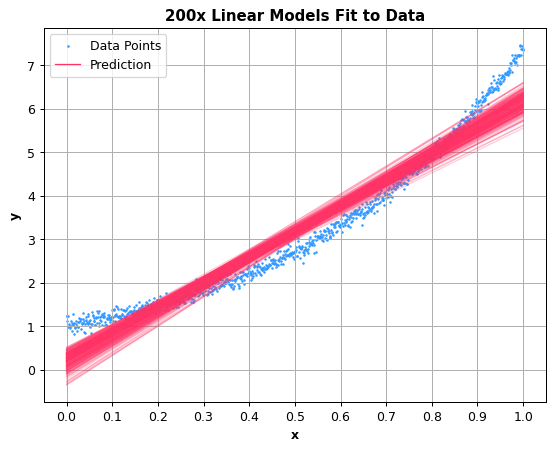

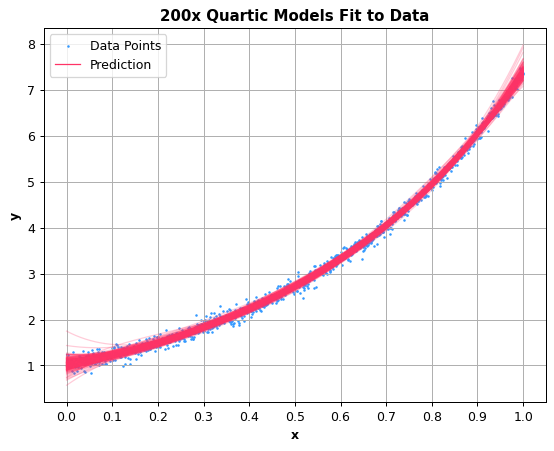

In [57]:
from matplotlib import pyplot as plt

for name, result in results_bvd.items():
    plot_data(x, y, scale=0.9)
    plt.title(f"{SAMPLE_COUNT}x {name} Models Fit to Data", fontweight="bold")
    plt.plot(x, result.samples[:, 0], c="#F36", lw=1, label="Prediction")
    plt.plot(x, result.samples[:, 1:], c="#F36", lw=1, alpha=0.25)
    plt.legend()

plt.show()

### Visualize the bias and variance of all the sampled models

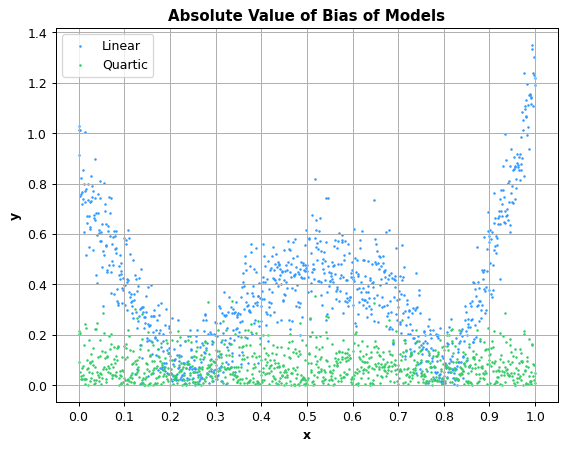

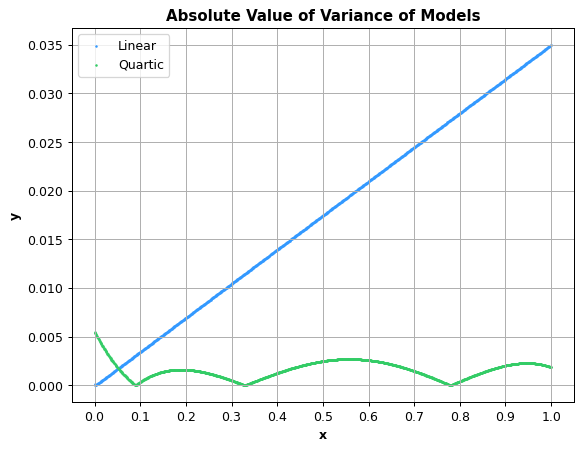

In [58]:
import matplotlib.pyplot as plt


PLOT_INFO = [
    ("bias", "Bias"),
    ("vars", "Variance"),
]

for key, name in PLOT_INFO:
    plot_data(x, results_bvd["Linear"].__dict__[key].abs(), scale=0.9, label="Linear")
    plt.scatter(
        x, results_bvd["Quartic"].__dict__[key].abs(), c="#3C6", s=1, label="Quartic"
    )
    plt.legend()
    plt.title(f"Absolute Value of {name} of Models", fontweight="bold")

plt.show()

## Discussion

The bias and variance values of each $x$ are shown in their absolute form for easier understanding.

In the bias plot, the linear model has **high bias** across most $x$ values, especially at the edges, which shows that its **simplicity** makes it unable to handle the data’s complexity. On the other hand, the quartic model, with its **greater complexity**, has **low bias**, meaning it fits the data **more accurately**.

The variance and prediction plots show that the linear model has a **wide spread** of predictions, meaning it struggles to adjust to more complex patterns, leading to **underfitting**. The quartic model, being more flexible due to its **higher complexity**, has **low variance** and offers a **good fit**.

Overall, the linear model’s **simplicity** results in both **high bias** and **underfitting**. Meanwhile, the quartic model, with its **greater complexity**, finds a better balance, fitting the data well without **overfitting**.

|  | Low Bias | High Bias |
| --- | --- | --- |
| **Low Variance** | Good fit (Quartic) | Underfitting |
| **High Variance** | Overfitting | Underfitting (Linear) |

# Problem 3

In `train.mat`, you will find 2-D points $\mathbf{X} = [\mathbf{x}_1\ \mathbf{x}_2]$ and their corresponding labels $\mathbf{Y} = \mathbf{y}$.

Please use logistic regression $h(\boldsymbol{\theta};\ \mathbf{x}) = \frac{1}{1 + e^{-\boldsymbol{\theta ^T \mathbf{x}}}}$ to find the decision boundary (optimal $\boldsymbol{\theta}^*$) based on `train.mat`.

## Solution

Let $\mathbf{X} = [1\ \mathbf{x}^{(1)}\ \mathbf{x}^{(2)}\ \ldots\ \mathbf{x}^{(p)}] \in \mathbb{R}^{n \times (p + 1)},\ \mathbf{Y} = \mathbf{y} \in \mathbb{R}^{n},\ \boldsymbol{\theta} = [\theta_0\ \theta_1\ \theta_2\ \ldots \theta_p]^{T} \in \mathbb{R}^{(p + 1) \times 1},\ n,\ p \in \mathbb{N}$.

The logistic regression model is $h(\boldsymbol{\theta};\ \mathbf{X}) = \frac{1}{1 + e^{-\mathbf{X} \boldsymbol{\theta}}}$.

To find the decision boundary, we can maximize the likelihood function $L(\boldsymbol{\theta}) = \prod_{i = 1}^{n} (h(\boldsymbol{\theta};\ \mathbf{x}_i))^{\mathbf{y}_i} (1 - h(\boldsymbol{\theta};\ \mathbf{x}_i))^{1 - \mathbf{y}_i}$.

$h(x) = \frac{1}{1 + e^{-x}}$ is strictly log-concave, since $\ln(h(x))'' = \frac{-e^{-x}}{(1 + e^{-x})^2} \lt 0$. Therefore, $L(\boldsymbol{\theta})$ is also strictly log-concave.

Minimizing $-\ln L(\boldsymbol{\theta})$ is equivalent to maximizing $L(\boldsymbol{\theta})$.

Since $-\ln L(\boldsymbol{\theta}) = \mathcal{L}(\boldsymbol{\theta})$ is a strictly convex function, we can approach its global minima using gradient descent.

$\nabla \mathcal{L}(\boldsymbol{\theta}) = \frac{\partial \mathcal{L}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}}$.

$\mathcal{L}(\boldsymbol{\theta}) = -\sum_{i = 1}^{n} \mathbf{y}_i \ln(h(\boldsymbol{\theta};\ \mathbf{x}_i)) + (1 - \mathbf{y}_i) \ln(1 - h(\boldsymbol{\theta};\ \mathbf{x}_i))$.

$\frac{\partial \mathcal{L}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = - \sum_{i = 1}^{n} (\mathbf{y}_i h(\boldsymbol{\theta};\ \mathbf{x}_i)^{-1} - (1 - \mathbf{y}_i)(1 - h(\boldsymbol{\theta};\ \mathbf{x}_i))^{-1}) \frac{\partial h(\boldsymbol{\theta};\ \mathbf{x}_i)}{\partial \boldsymbol{\theta}}
\newline
\hskip2.36em = - \sum_{i = 1}^{n} (\mathbf{y}_i h(\boldsymbol{\theta};\ \mathbf{x}_i)^{-1} - (1 - \mathbf{y}_i)(1 - h(\boldsymbol{\theta};\ \mathbf{x}_i))^{-1}) h(\boldsymbol{\theta};\ \mathbf{x}_i) (1 - h(\boldsymbol{\theta};\ \mathbf{x}_i)) \mathbf{x}_i
\newline
\hskip2.36em = - \sum_{i = 1}^{n} (\mathbf{y}_i - h(\boldsymbol{\theta};\ \mathbf{x}_i)) \mathbf{x}_i
\newline
\hskip2.36em = (h(\boldsymbol{\theta};\ \mathbf{X}) - \mathbf{Y})^{T} \mathbf{X}$.

The optimization process can be written as $\boldsymbol{\theta}_{t + 1} \leftarrow \boldsymbol{\theta}_t - \alpha \nabla \mathcal{L}(\boldsymbol{\theta}_t)$.

The optimal $\boldsymbol{\theta}^*$ can be found by iterating gradient descent until convergence.

# Problem 3.1

Plot the 2-D data points and the decision boundary on the same graph to visually illustrate the model's separation of classes.

## Solution

# Problem 3.2

Evaluate the model on the test dataset (`test.mat`) and report the test error, defined as the percentage of misclassified test samples.

## Solution

# Problem 4

Download the MNIST dataset using the following example code: 

```python
# The code is moved to the solution code cell.
```

Please randomly choose 5,000 handwritten images from either the training or the testing dataset to construct your own dataset, with 500 data samples for each digit.

## Solution

In [67]:
SEED = 2
SIZE_PER_TARGET = 500

import torch
from torchvision.datasets import MNIST
from tempfile import tempdir

torch.manual_seed(SEED)

dataset = MNIST(tempdir, download=True, train=False)
scatter_indices = torch.randperm(len(dataset))
X = dataset.data[scatter_indices]
Y = dataset.targets[scatter_indices]
X, Y = map(
    torch.cat,
    zip(
        *(
            (X[Y == y][:SIZE_PER_TARGET], torch.full((SIZE_PER_TARGET, 1), y))
            for y in Y.unique()
        )
    ),
)

display(dict(X_shape=tuple(X.shape), Y_shape=tuple(Y.shape)))

{'X_shape': (5000, 28, 28), 'Y_shape': (5000, 1)}

# Problem 4.1

Use the following code to show 50 images in your own dataset.

```python
# The code is moved to the solution code cell.
```

## Solution

In [60]:
import numpy as np
import matplotlib.pyplot as plt

amount = 50
lines = 5
columns = 10
number = np.zeros(amount)

for i in range(amount):
    number[i] = y_test[i]

fig = plt.figure()

for i in range(amount):
    ax = fig.add_subplot(lines, columns, 1 + i)
    plt.imshow(x_test[i, :, :], cmap="binary")
    plt.sca(ax)
    ax.set_xticks([], [])
    ax.set_yticks([], [])

plt.show()

NameError: name 'y_test' is not defined

# Problem 4.2

Apply PCA (Principal Component Analysis) to reduce the 784-dimensional data to 500, 300, 100, and 50 dimensions. For each reduction, show ten decoded results for each digit and analyze how the data reconstruction changes with decreasing dimensions.

In your report, interpret the results by discussing how the dimensionality reduction affects the quality of the decoded images and explain any observed trade-offs between dimensionality and image clarity.

## Solution

# Problem 4.3

Use PCA to project the MNIST dataset down to 2D and sample at least 4 decoded images from different regions across the four quadrants of this 2D projection.

## Solution